# Tutorial - Introduction to Lightwood's statistical analysis


As you might already know, Lightwood is designed to be a flexible machine learning (ML) library that is able to abstract and automate the entire ML pipeline. Crucially, it is also designed to be extended or modified very easily according to your needs, essentially offering the entire spectrum between fully automated AutoML and a lightweight wrapper for customized ML pipelines.

As such, we can identify several different customizable "phases" in the process. The relevant phase for this tutorial is the "statistical analysis" that is normally ran in two different places:

* To generate a Json AI object from some dataset and a problem definition
* To train a Lightwood predictor

In both cases, we leverage the `StatisticalAnalyzer` object from `dataprep_ml` (another ML package in the MindsDB ecosystem) to store key facts about the data we are using, and refer to them afterwards.

## Objective

In this tutorial, we will take a look at the automatically generated statistical analysis for a sample dataset.

## Step 1: load the dataset and define the predictive task

The first thing we need is a dataset to analyze. Let's use Human Development Index information:

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/mindsdb/lightwood/stable/tests/data/hdi.csv')
df.head()

,Population,Area (sq. mi.),Pop. Density,GDP ($ per capita),Literacy (%),Infant mortality,Development Index
0,9944201,1284000,7.7,1200,47.5,93.82,2
1,5450661,43094,126.5,31100,100.0,4.56,4
2,26783383,437072,61.3,1500,40.4,50.25,2
3,9439,102,92.5,3400,97.0,7.35,4
4,3431932,176220,19.5,12800,98.0,11.95,3


This dataset has a handful of important factors to each country's development index, as well as the index itself (very high, high, medium or low). Each row gives information about a country's status in terms of their population size, density, and GDP per capita, among others.

We can see there are columns with integer (e.g. `Population`), float (`Pop. Density`) or categorical (e.g. `Development Index`) data.

The task we will consider here is to predicting the development index of each nation based on the rest of the available information.

Lightwood provides an abstraction called `ProblemDefinition` to specify the target column of a dataset, along with other important parameters that you might want to define (for a complete list, check the documentation).

We will create a simple one:

In [2]:
from lightwood.api.high_level import ProblemDefinition

problem_definition = ProblemDefinition.from_dict({'target': 'Development Index'})

INFO:lightwood-3000:No torchvision detected, image helpers not supported.
INFO:lightwood-3000:No torchvision/pillow detected, image encoder not supported
/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/gluonts/model/deepar/__init__.py:18: FutureWarning: The module gluonts.model.deepar has been moved to gluonts.mx.model.deepar. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import DeepAREstimator'.
  warnings.warn(


Let's see how this object has been populated. `ProblemDefinition` is a Python `dataclass`, so it comes with some convenient tools to achieve this:

In [3]:
from dataclasses import fields

{field.name: getattr(problem_definition, field.name) for field in fields(ProblemDefinition)}

{'target': 'Development Index',
 'pct_invalid': 2,
 'unbias_target': True,
 'seconds_per_mixer': None,
 'seconds_per_encoder': None,
 'expected_additional_time': None,
 'time_aim': None,
 'target_weights': None,
 'positive_domain': False,
 'timeseries_settings': TimeseriesSettings(is_timeseries=False, order_by=None, window=None, group_by=None, use_previous_target=True, horizon=None, historical_columns=None, target_type='', allow_incomplete_history=True, eval_incomplete=False, interval_periods=()),
 'anomaly_detection': False,
 'use_default_analysis': True,
 'dtype_dict': {},
 'ignore_features': [],
 'fit_on_all': True,
 'strict_mode': True,
 'seed_nr': 1}

Notice how, even though we only defined what the `target` was, there are a bunch of additional parameters that have been assigned a default value. That is fine for our purposes, but remember that you can set any of these according to your own predictive needs.

We also need to infer the type of each column. For this, we can use `type_infer` (another ML library from the MindsDB ecosystem), specialized in automated type inference for datasets. In particular, we'll use `type_infer.infer.infer_types`:

In [4]:
from type_infer.infer import infer_types
from type_infer.base import TypeInformation

type_information = infer_types(df, problem_definition.pct_invalid)

{field.name for field in fields(TypeInformation)}  # show the fields this dataclass has

INFO:type_infer-3000:Analyzing a sample of 222
INFO:type_infer-3000:from a total population of 225, this is equivalent to 98.7% of your data.
INFO:type_infer-3000:Infering type for: Population
INFO:type_infer-3000:Column Population has data type integer
INFO:type_infer-3000:Infering type for: Area (sq. mi.)
INFO:type_infer-3000:Column Area (sq. mi.) has data type integer
INFO:type_infer-3000:Infering type for: Pop. Density 
INFO:type_infer-3000:Column Pop. Density  has data type float
INFO:type_infer-3000:Infering type for: GDP ($ per capita)
INFO:type_infer-3000:Column GDP ($ per capita) has data type integer
INFO:type_infer-3000:Infering type for: Literacy (%)
INFO:type_infer-3000:Column Literacy (%) has data type float
INFO:type_infer-3000:Infering type for: Infant mortality 
INFO:type_infer-3000:Column Infant mortality  has data type float
INFO:type_infer-3000:Infering type for: Development Index
INFO:type_infer-3000:Column Development Index has data type categorical


{'additional_info', 'dtypes', 'identifiers'}

We can now check the inferred types:

In [5]:
type_information.dtypes

{'Population': 'integer',
 'Area (sq. mi.)': 'integer',
 'Pop. Density ': 'float',
 'GDP ($ per capita)': 'integer',
 'Literacy (%)': 'float',
 'Infant mortality ': 'float',
 'Development Index': 'categorical'}

Looks OK!

## Step 2: Run the statistical analysis

We now have all the necessary ingredients to run the statistical analysis. Normally, you would ask Lightwood for a Json AI object to be generated according to the dataset and the problem definition. Internally, Lightwood will then run the statistical analysis for the provided dataset, and store it for later usage.

Afterwards, you would make modifications to the Json AI as needed (for some examples, check out the other tutorials in `lightwood/examples/json_ai`), and finally generate a predictor object to learn and predict the task.

In this case though, we will call it directly:

In [6]:
from dataprep_ml.insights import StatisticalAnalysis  # the class where everything is stored
from dataprep_ml.insights import statistical_analysis # generates an instance of the class

stan = statistical_analysis(df, 
                            type_information.dtypes, 
                            problem_definition.to_dict(),
                            type_information.identifiers)

INFO:dataprep_ml-3000:Starting statistical analysis
INFO:dataprep_ml-3000:Finished statistical analysis


## Step 3: Peeking inside

Now that our analysis is complete, we can check what Lightwood thinks of this dataset:

In [7]:
{field.name for field in fields(StatisticalAnalysis)}  # show the fields this dataclass has

{'avg_words_per_sentence',
 'bias',
 'buckets',
 'df_target_stddev',
 'distinct',
 'histograms',
 'missing',
 'nr_columns',
 'nr_rows',
 'positive_domain',
 'target_class_distribution',
 'target_weights',
 'train_observed_classes',
 'ts_stats'}

Some of these fields aren't really applicable nor useful for this dataset, so let's only check the ones that are. 

We can start with a very basic question: how many rows does the dataset have?

In [8]:
stan.nr_rows

225

Here are some other insights produced in the analysis:

### Amount of missing information

Is there missing information in the dataset?

In [9]:
stan.missing

{'Population': {'missing': 0.0,
  'description': 'Proportion of missing values for the column. Columns with high % of missing values may not be as useful for modelling purposes.'},
 'Area (sq. mi.)': {'missing': 0.0,
  'description': 'Proportion of missing values for the column. Columns with high % of missing values may not be as useful for modelling purposes.'},
 'Pop. Density ': {'missing': 0.0,
  'description': 'Proportion of missing values for the column. Columns with high % of missing values may not be as useful for modelling purposes.'},
 'GDP ($ per capita)': {'missing': 0.0,
  'description': 'Proportion of missing values for the column. Columns with high % of missing values may not be as useful for modelling purposes.'},
 'Literacy (%)': {'missing': 0.0,
  'description': 'Proportion of missing values for the column. Columns with high % of missing values may not be as useful for modelling purposes.'},
 'Infant mortality ': {'missing': 0.0,
  'description': 'Proportion of missing

Seemingly not!

### Buckets per column

For numerical colums, values are bucketized into discrete ranges.

Each categorical column gets a bucket per each observed class.

Let's check an example for one of each:

In [10]:
stan.buckets['Development Index']  # categorical

['3', '4', '2', '1']

In [11]:
stan.buckets['GDP ($ per capita)']  # numerical

[500,
 1592,
 2684,
 3776,
 4868,
 5960,
 7052,
 8144,
 9236,
 10328,
 11420,
 12512,
 13604,
 14696,
 15788,
 16880,
 17972,
 19064,
 20156,
 21248,
 22340,
 23432,
 24524,
 25616,
 26708,
 27800,
 28892,
 29984,
 31076,
 32168,
 33260,
 34352,
 35444,
 36536,
 37628,
 38720,
 39812,
 40904,
 41996,
 43088,
 44180,
 45272,
 46364,
 47456,
 48548,
 49640,
 50732,
 51824,
 52916,
 54008]

### Bias per column

We can also check whether each column has buckets of data that exhibit some degree of bias:

In [12]:
for colname, col in stan.bias.items():
    print(f"'{colname}' entropy: {round(col['entropy'], 3)}")
    print(f"Biased buckets: {col['biased_buckets']}\n" if col['biased_buckets'] else '\n')

'Population' entropy: 0.212
Biased buckets: [131403695, 78845027, 52565693, 26286360, 7026]

'Area (sq. mi.)' entropy: 0.294


'Pop. Density ' entropy: 0.143
Biased buckets: [650.86, 6183.17, 976.29, 325.43, 0.0]

'GDP ($ per capita)' entropy: 0.76


'Literacy (%)' entropy: 0.753


'Infant mortality ' entropy: 0.767


'Development Index' entropy: 0.89




### Column histograms

Finally, let's plot histograms for some columns:

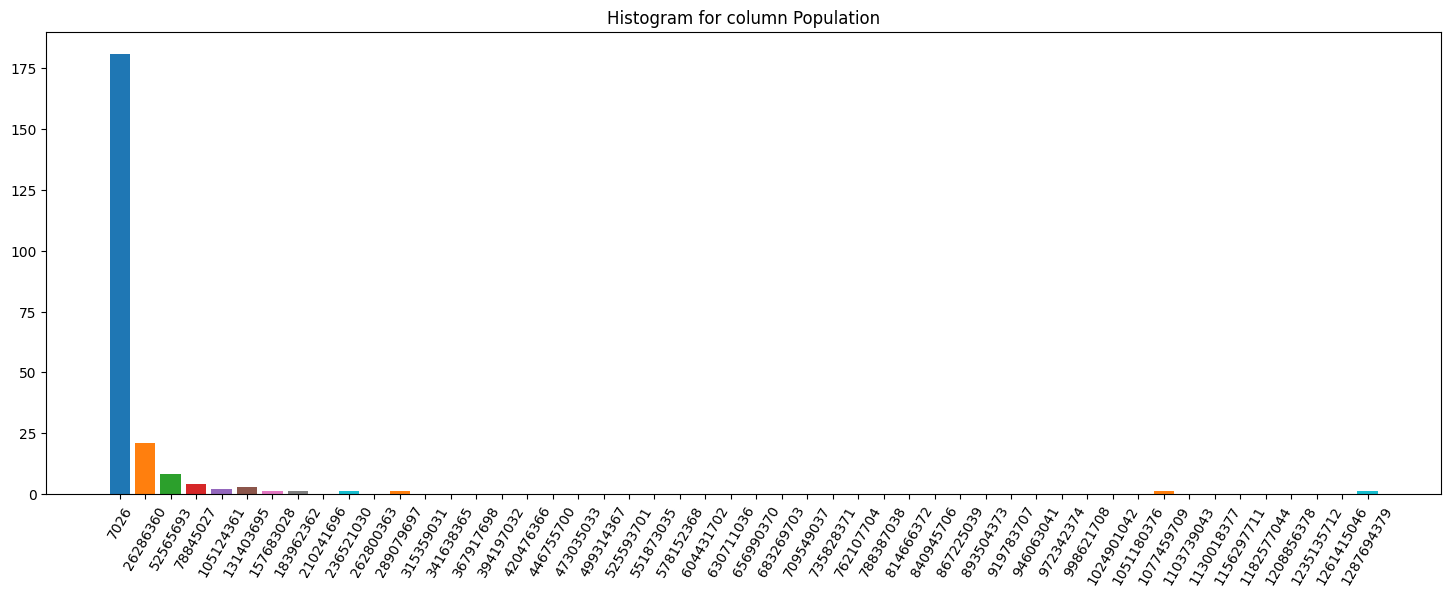

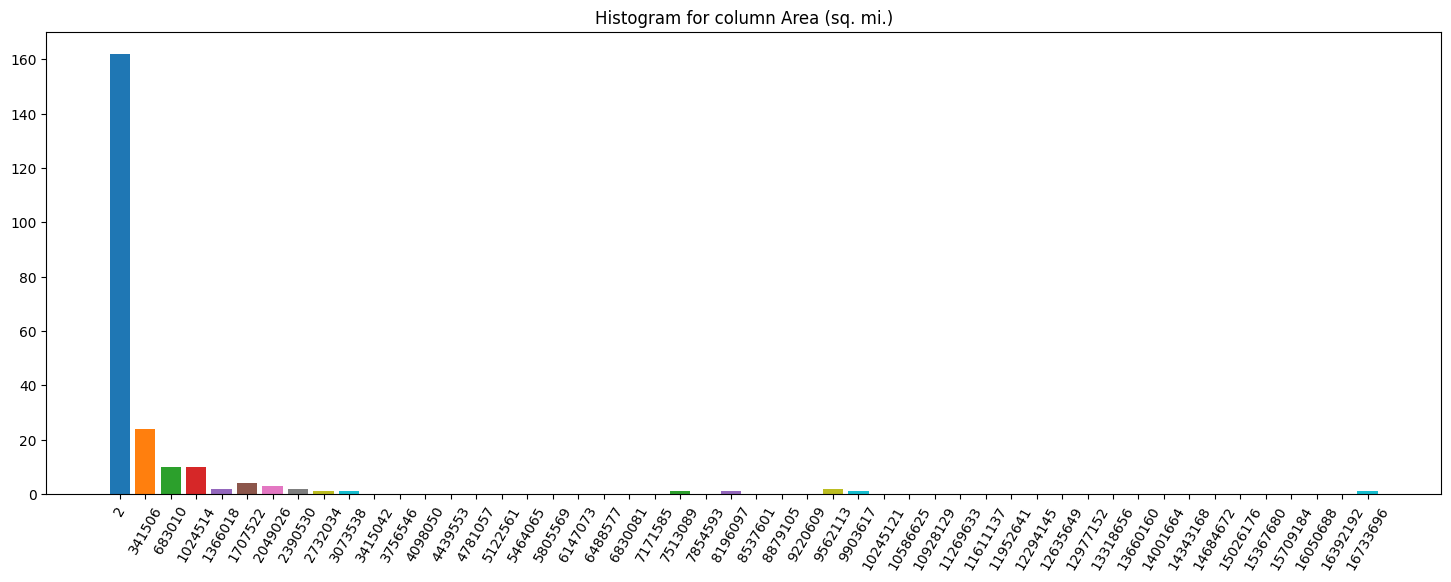

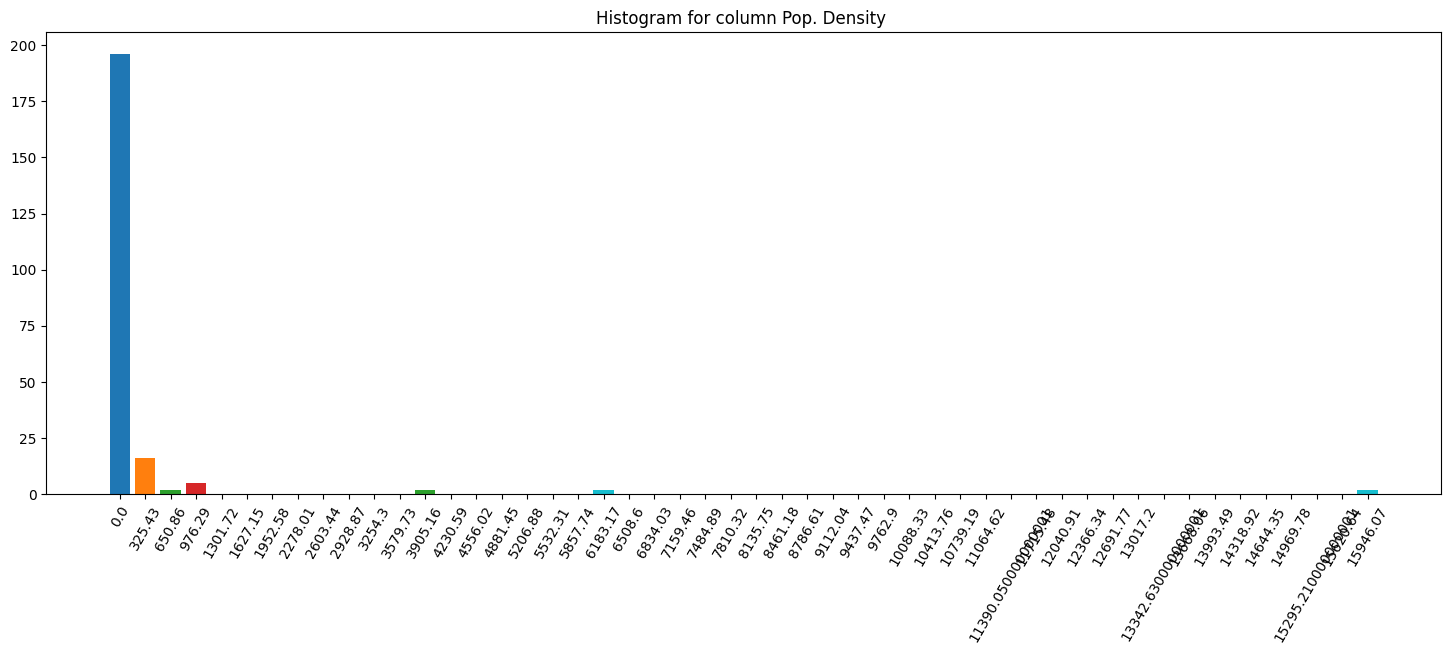

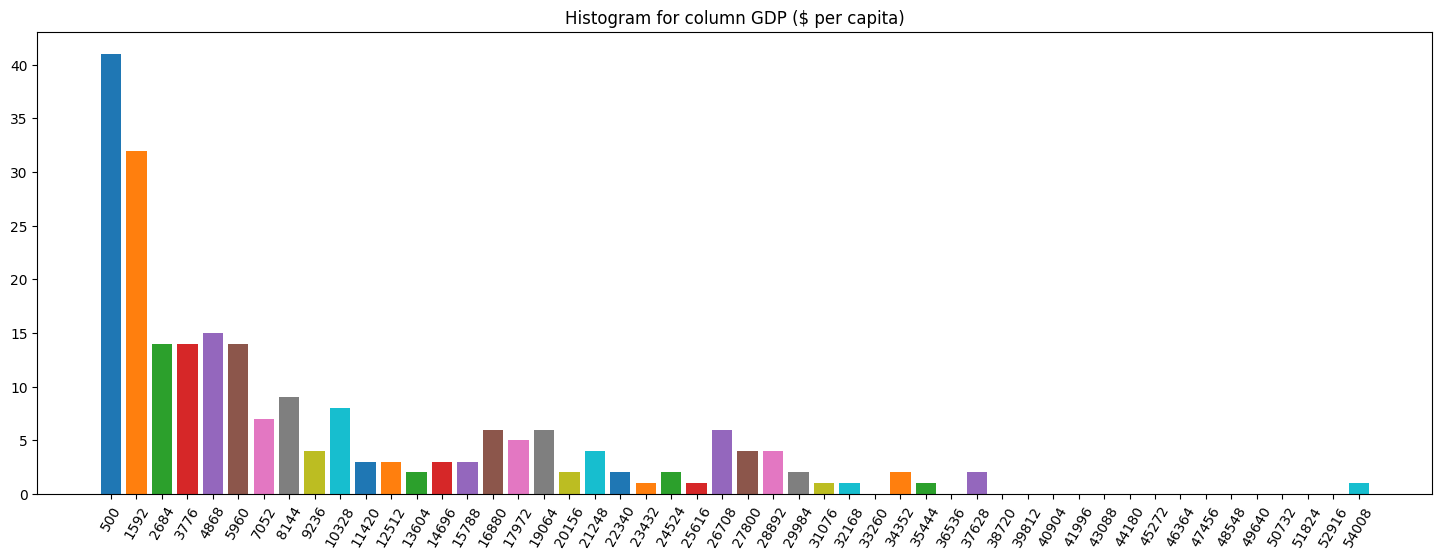

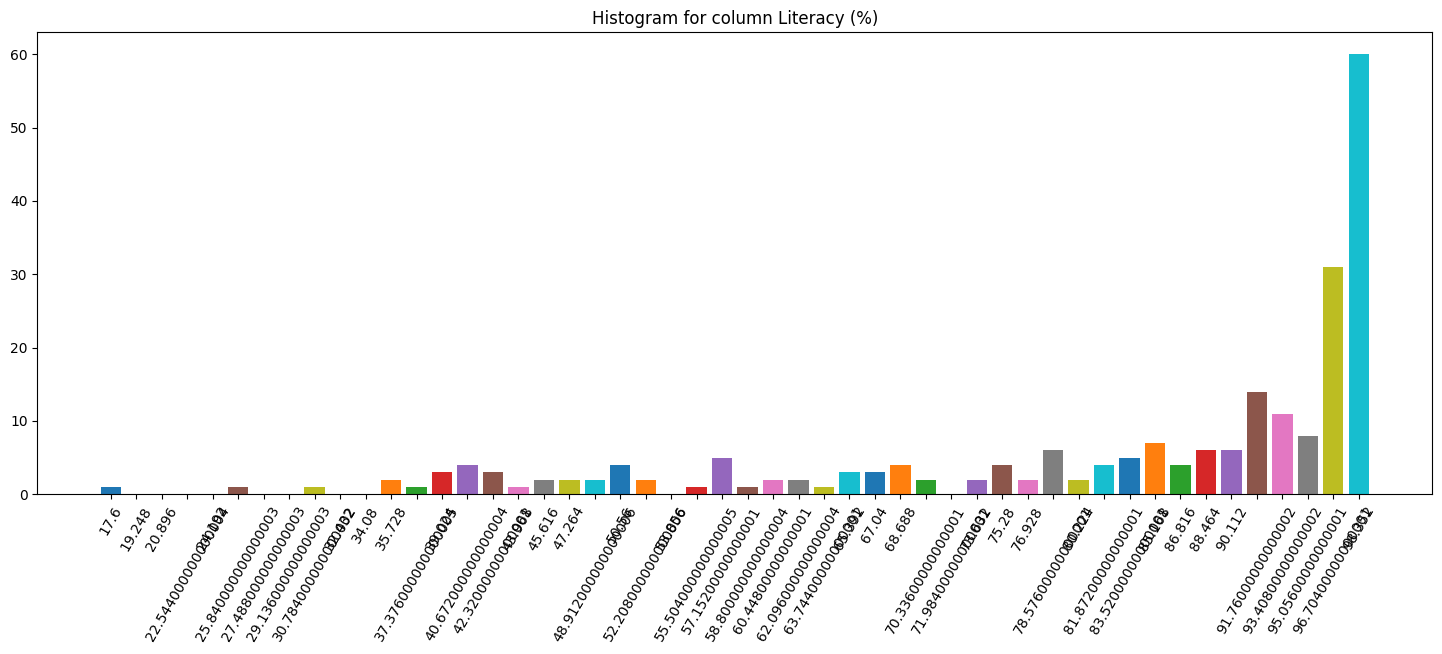

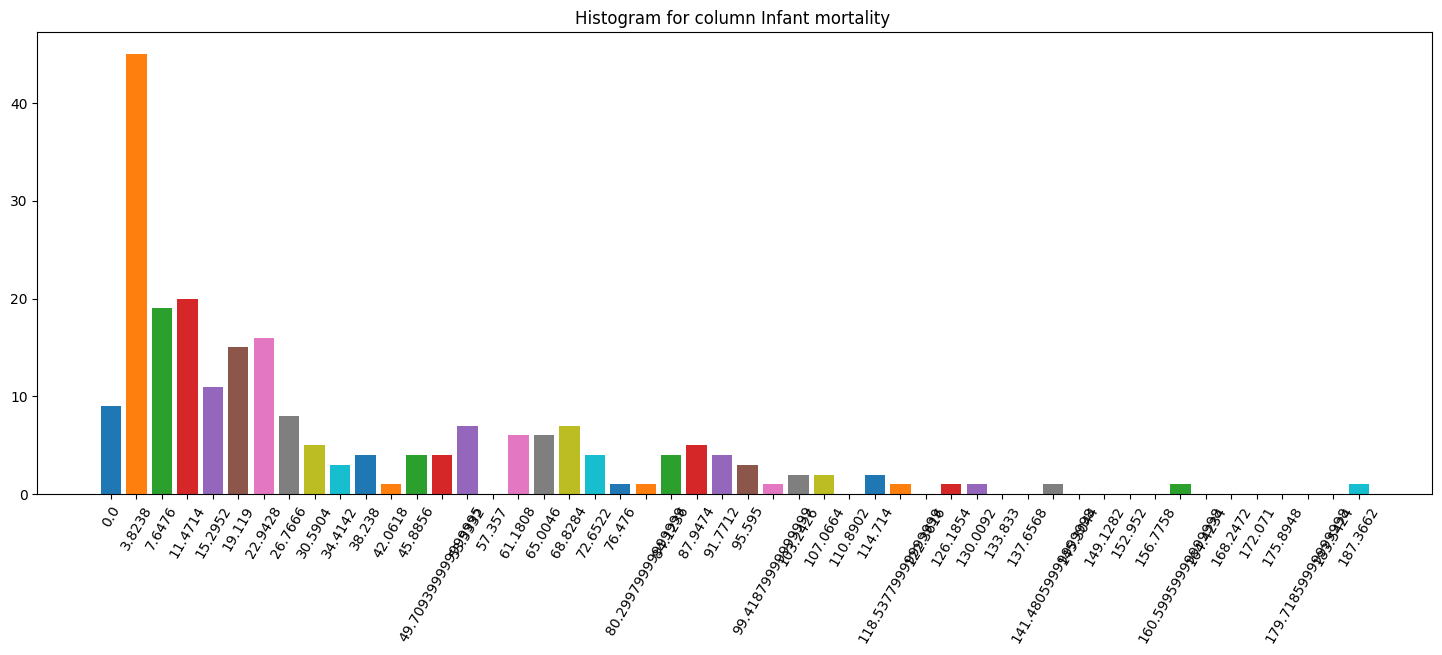

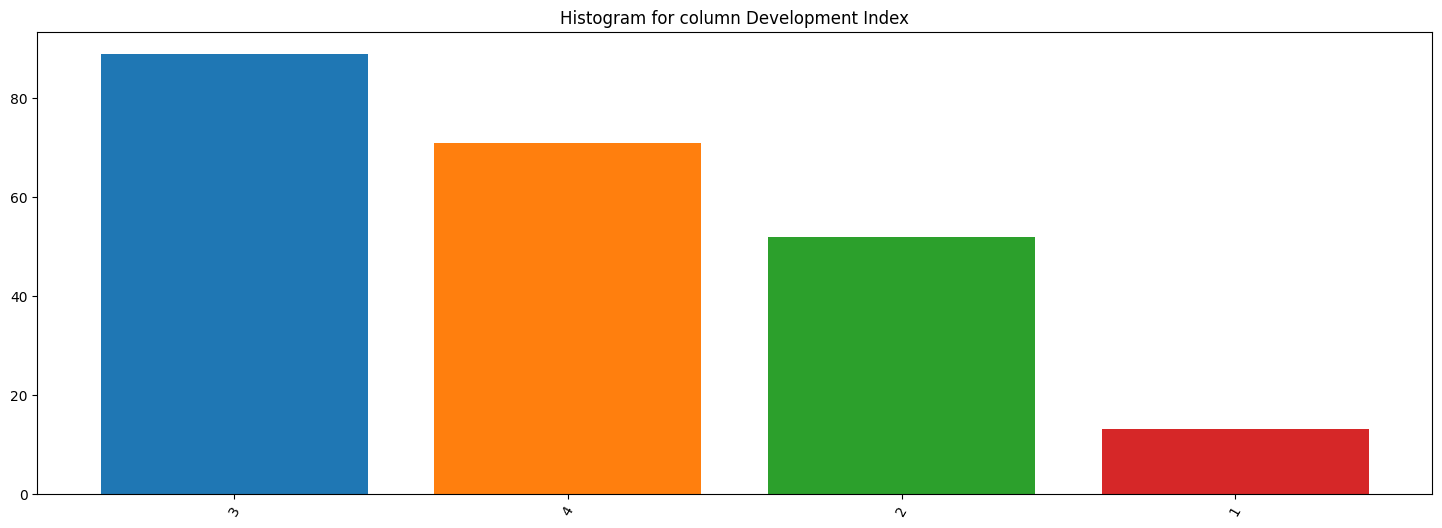

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# generate color map
cmap = plt.cm.tab10
colors = cmap(np.arange(len(df)) % cmap.N)

# column barplot
columns = []
for colname, hist in stan.histograms.items():
    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.bar(np.arange(len(hist['x'])), hist['y'], color=colors)
    ax.set_xticks(np.arange(len(hist['x'])))
    ax.set_xticklabels(hist['x'], rotation=60)
    ax.set_title(f"Histogram for column {colname}")
    
    plt.show()

This way, it is fairly easy to understand how imbalanced the target distribution might be, along with a quick pass to search for outliers, for example.

# Final thoughts

Lightwood automatically tries to leverage all the information provided by a `StatisticalAnalysis` instance when generating a predictor for any given dataset and problem definition. Additionally, it is a valuable tool to explore the data as a user. 

Finally, be aware that you can access these insights when creating custom blocks (e.g. encoders, mixers, or analyzers) if you want, you just need to pass whatever is necessary as arguments to these blocks inside the Json AI object.
